# MONTE CARLO WITHOUT BASELINE - ACROBOT-v1

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


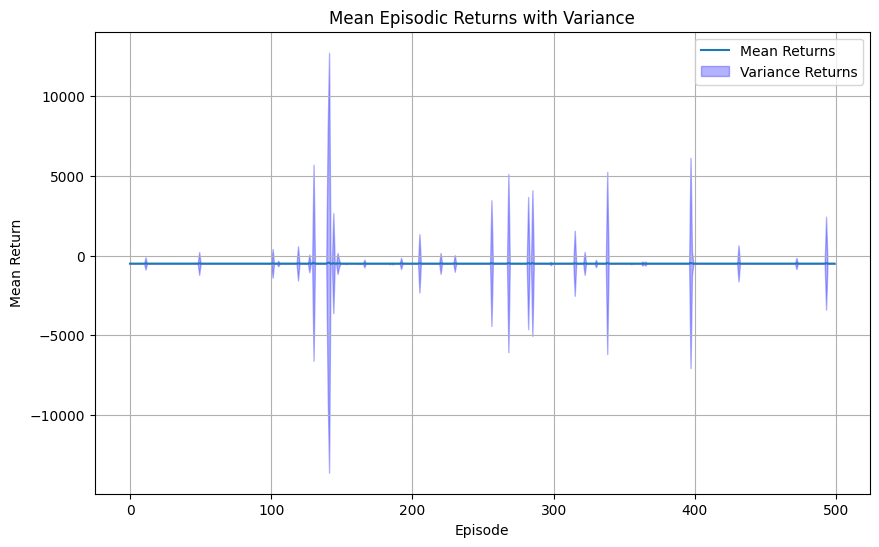

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Function to discretize the state space
def discretize_state(state, bins):
    return tuple(np.digitize(s, b) - 1 for s, b in zip(state, bins))

# Function to generate an episode
def generate_episode(env, policy_func, bins):
    states = []
    actions = []
    rewards = []
    state = discretize_state(env.reset(), bins)

    done = False
    while not done:
        action = policy_func(state)
        next_state, reward, done, _ = env.step(action)

        next_state = discretize_state(next_state, bins)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards


# Function to update policy based on returns
def update_policy(policy, returns, states, actions):
    for t, state in enumerate(states):
        action = actions[t]
        G = sum(returns[t:])
        policy[state][action] += G

# Function to train the policy
def train_policy(env_name, num_episodes, gamma, alpha, bins, seeds):
    env = gym.make(env_name)
    num_actions = env.action_space.n
    policy = {}
    for state in bins:
        policy[discretize_state(state, bins)] = np.ones(num_actions) / num_actions  # Initialize with equal probabilities for each action

    episode_returns = np.zeros((len(seeds), num_episodes))

    for seed_idx, seed in enumerate(seeds):
        env.seed(seed)
        np.random.seed(seed)

        for episode in range(num_episodes):
            states, actions, rewards = generate_episode(env, lambda s: np.random.choice(num_actions, p=policy.get(discretize_state(s, bins), np.ones(num_actions) / num_actions)), bins)
            returns = []
            G = 0

            for t in range(len(states) - 1, -1, -1):
                G = gamma * G + rewards[t]
                state = states[t]
                action = actions[t]
                policy[state] = policy.get(state, np.ones(num_actions) / num_actions)  # Ensure state exists in policy
                policy[state][action] += G

                returns.insert(0, G)

            episode_returns[seed_idx, episode] = sum(rewards)

    for state in policy:
        policy[state] /= np.sum(policy[state])  # Normalize policy probabilities

    return episode_returns

def plot_results(episode_returns):
    mean_returns = np.mean(episode_returns, axis=0)
    variance_returns = np.var(episode_returns, axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_returns, label='Mean Returns')
    plt.fill_between(range(len(mean_returns)), mean_returns - variance_returns, mean_returns + variance_returns, color='blue', alpha=0.3, label='Variance Returns')
    plt.title('Mean Episodic Returns with Variance')
    plt.xlabel('Episode')
    plt.ylabel('Mean Return')
    plt.legend()
    plt.grid(True)
    plt.show()


# Main function
def main():
    env_name = 'Acrobot-v1'
    num_episodes = 500
    gamma = 0.99
    alpha = 0.1  # Learning rate
    bins = [np.linspace(-1.2, 1.2, 10), np.linspace(-1.2, 1.2, 10), np.linspace(-1.2, 1.2, 10), np.linspace(-1.2, 1.2, 10), np.linspace(-12.566370614359172, 12.566370614359172, 10), np.linspace(-28.274333882308138, 28.274333882308138, 10)]  # Define bins for discretization
    seeds = [10, 20, 30, 40, 50]  # 5 random seeds

    episode_returns = train_policy(env_name, num_episodes, gamma, alpha, bins, seeds)
    plot_results(episode_returns)

if __name__ == "__main__":
    main()

# MONTE CARLO WITH BASELINE - ACROBOT v1

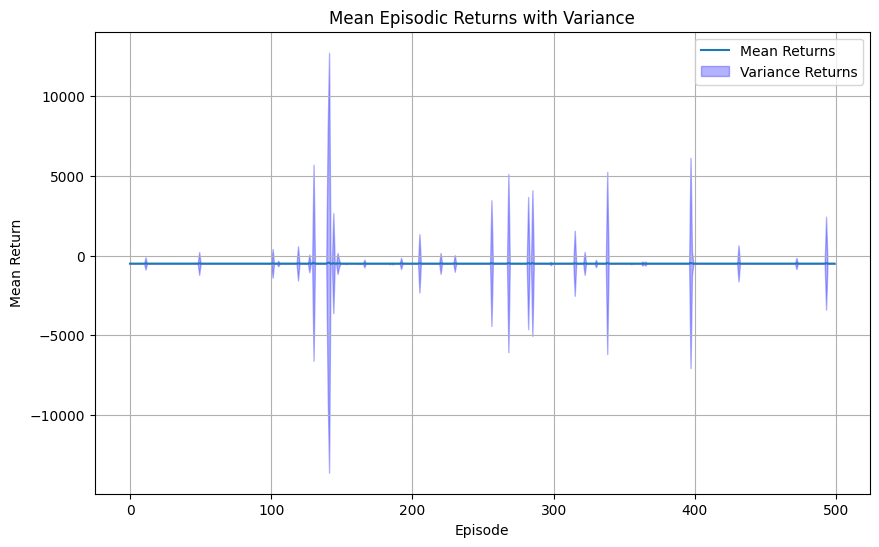

In [4]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Function to discretize the state space
def discretize_state(state, bins):
    return tuple(np.digitize(s, b) - 1 for s, b in zip(state, bins))

# Function to generate an episode
def generate_episode(env, policy_func, bins):
    states = []
    actions = []
    rewards = []
    state = discretize_state(env.reset(), bins)

    done = False
    while not done:
        action = policy_func(state)
        next_state, reward, done, _ = env.step(action)

        next_state = discretize_state(next_state, bins)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards

# Function to update policy based on returns
def update_policy(policy, returns, states, actions):
    for t, state in enumerate(states):
        action = actions[t]
        G = sum(returns[t:])
        policy[state][action] += G

# Function to train the policy with a baseline
def train_policy(env_name, num_episodes, gamma, alpha, bins, seeds):
    env = gym.make(env_name)
    num_actions = env.action_space.n
    policy = {}
    baseline = {}
    for state in bins:
        policy[discretize_state(state, bins)] = np.ones(num_actions) / num_actions  # Initialize with equal probabilities for each action
        baseline[discretize_state(state, bins)] = 0  # Initialize baseline to zero

    episode_returns = np.zeros((len(seeds), num_episodes))

    for seed_idx, seed in enumerate(seeds):
        env.seed(seed)
        np.random.seed(seed)

        for episode in range(num_episodes):
            states, actions, rewards = generate_episode(env, lambda s: np.random.choice(num_actions, p=policy.get(discretize_state(s, bins), np.ones(num_actions) / num_actions)), bins)
            returns = []
            G = 0

            for t in range(len(states) - 1, -1, -1):
                G = gamma * G + rewards[t]
                state = states[t]
                action = actions[t]
                if state not in policy:
                    continue  # Skip if state is not in policy
                baseline[state] += alpha * (G - baseline[state])  # Update baseline with incremental average
                policy[state] = policy.get(state, np.ones(num_actions) / num_actions)  # Ensure state exists in policy
                policy[state][action] += alpha * (G - baseline[state])  # Update policy with incremental average

                returns.insert(0, G)

            episode_returns[seed_idx, episode] = sum(rewards)

    for state in policy:
        policy[state] /= np.sum(policy[state])  # Normalize policy probabilities

    return episode_returns

# Function to plot results
def plot_results(episode_returns):
    mean_returns = np.mean(episode_returns, axis=0)
    variance_returns = np.var(episode_returns, axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_returns, label='Mean Returns')
    plt.fill_between(range(len(mean_returns)), mean_returns - variance_returns, mean_returns + variance_returns, color='blue', alpha=0.3, label='Variance Returns')
    plt.title('Mean Episodic Returns with Variance')
    plt.xlabel('Episode')
    plt.ylabel('Mean Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main():
    env_name = 'Acrobot-v1'
    num_episodes = 500
    gamma = 0.99
    alpha = 0.1  # Learning rate
    bins = [
        np.linspace(-1.2, 1.2, 10),   # First dimension
        np.linspace(-1.2, 1.2, 10),   # Second dimension
        np.linspace(-0.07, 0.07, 10), # Third dimension
        np.linspace(-0.07, 0.07, 10), # Fourth dimension
        np.linspace(-0.42, 0.42, 10), # Fifth dimension
        np.linspace(-0.42, 0.42, 10)  # Sixth dimension
    ]  # Define bins for discretization
    seeds = [10, 20, 30, 40, 50]  # 5 random seeds

    episode_returns = train_policy(env_name, num_episodes, gamma, alpha, bins, seeds)
    plot_results(episode_returns)

if __name__ == "__main__":
    main()


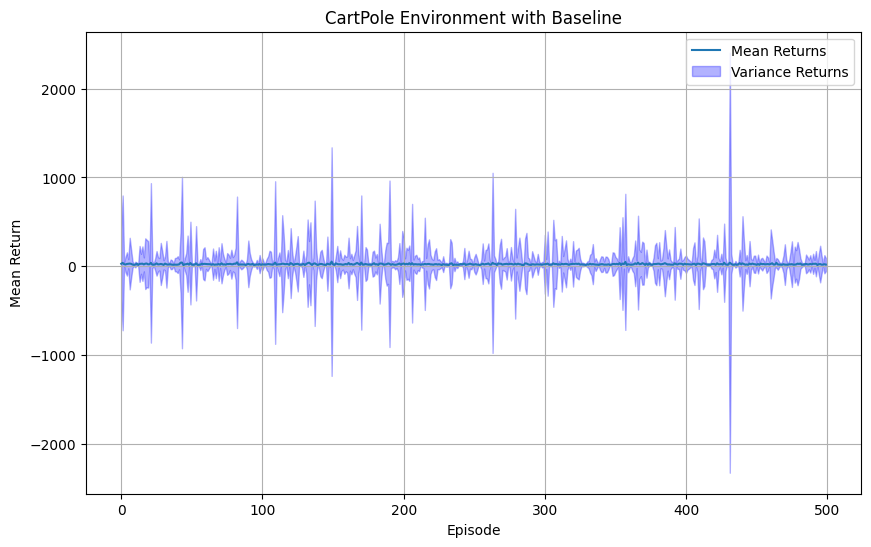

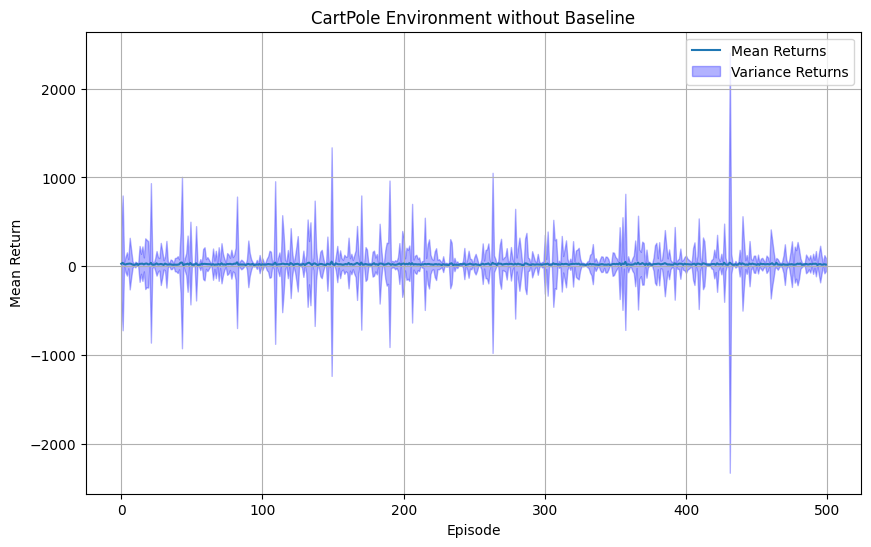

In [6]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Function to discretize the state space
def discretize_state(state, bins):
    return tuple(np.digitize(s, b) - 1 for s, b in zip(state, bins))

# Function to generate an episode
def generate_episode(env, policy, bins):
    states = []
    actions = []
    rewards = []
    state = discretize_state(env.reset(), bins)

    done = False
    while not done:
        action = policy(state)  # Call policy function directly
        next_state, reward, done, _ = env.step(action)

        next_state = discretize_state(next_state, bins)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards

# Function to update policy based on returns
def update_policy(policy, returns, states, actions):
    for t, state in enumerate(states):
        action = actions[t]
        G = sum(returns[t:])
        policy[state][action] += G

# Function to train the policy with a baseline
def train_policy(env_name, num_episodes, gamma, alpha, bins, seeds, with_baseline=True):
    env = gym.make(env_name)
    num_actions = env.action_space.n
    policy = {}
    baseline = {} if with_baseline else None
    for state in bins:
        policy[discretize_state(state, bins)] = np.ones(num_actions) / num_actions  # Initialize with equal probabilities for each action
        if with_baseline:
            baseline[discretize_state(state, bins)] = 0  # Initialize baseline to zero

    episode_returns = np.zeros((len(seeds), num_episodes))

    for seed_idx, seed in enumerate(seeds):
        env.seed(seed)
        np.random.seed(seed)

        for episode in range(num_episodes):
            states, actions, rewards = generate_episode(env, lambda s: np.random.choice(num_actions, p=policy.get(discretize_state(s, bins), np.ones(num_actions) / num_actions)), bins)
            returns = []
            G = 0

            for t in range(len(states) - 1, -1, -1):
                G = gamma * G + rewards[t]
                state = states[t]
                action = actions[t]
                if state not in policy:
                    continue  # Skip if state is not in policy
                if with_baseline:
                    baseline[state] += alpha * (G - baseline[state])  # Update baseline with incremental average
                policy[state] = policy.get(state, np.ones(num_actions) / num_actions)  # Ensure state exists in policy
                if with_baseline:
                    policy[state][action] += alpha * (G - baseline[state])  # Update policy with incremental average
                else:
                    policy[state][action] += alpha * G  # Update policy without baseline

                returns.insert(0, G)

            episode_returns[seed_idx, episode] = sum(rewards)

    for state in policy:
        policy[state] /= np.sum(policy[state])  # Normalize policy probabilities

    return episode_returns

# Function to plot results
def plot_results(episode_returns, title):
    mean_returns = np.mean(episode_returns, axis=0)
    variance_returns = np.var(episode_returns, axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_returns, label='Mean Returns')
    plt.fill_between(range(len(mean_returns)), mean_returns - variance_returns, mean_returns + variance_returns, color='blue', alpha=0.3, label='Variance Returns')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Mean Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main():
    env_name = 'CartPole-v1'
    num_episodes = 500
    gamma = 0.99
    alpha = 0.1  # Learning rate
    bins = [
        np.linspace(-2.4, 2.4, 10),     # Cart position
        np.linspace(-2, 2, 10),         # Cart velocity
        np.linspace(-0.21, 0.21, 10),   # Pole angle
        np.linspace(-3.5, 3.5, 10)      # Pole velocity at tip
    ]  # Define bins for discretization
    seeds = [10, 20, 30, 40, 50]  # 5 random seeds

    episode_returns_with_baseline = train_policy(env_name, num_episodes, gamma, alpha, bins, seeds, with_baseline=True)
    plot_results(episode_returns_with_baseline, 'CartPole Environment with Baseline')

    episode_returns_without_baseline = train_policy(env_name, num_episodes, gamma, alpha, bins, seeds, with_baseline=False)
    plot_results(episode_returns_without_baseline, 'CartPole Environment without Baseline')

if __name__ == "__main__":
    main()
